# Data Normalization for Clustering

In this step, I'm normalizing the data by handling missing values, scaling features, categorical encoding (if necessary), and saving the normalized data for clustering.

In [38]:
import pandas as pd
import pprint
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN

df = pd.read_csv("../data/interim/weather_per_country.csv")

numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
sustainability_vars = numeric_cols.drop(
    ["number_of_datapoints"]
)  # Exclude non-sustainability variables

## Handling missing values

As we already aggregated data and cleaned up countries with too few datapoints, there should be no missing values left. Let's verify this. Same should apply for outliers.

In [39]:
print(df.isnull().sum())

lower_quantiles = df[numeric_cols].quantile(0.05)
upper_quantiles = df[numeric_cols].quantile(0.95)

outlier_counts_quantile = {}
for col_name in numeric_cols:
    outlier_mask = (df[col_name] < lower_quantiles[col_name]) | (
        df[col_name] > upper_quantiles[col_name]
    )
    outlier_counts_quantile[col_name] = outlier_mask.sum()

print("Outlier counts per column (10% and 90% quantiles):")
pprint.pprint(outlier_counts_quantile)

country                               0
temperature_min                       0
temperature_max                       0
temperature_mean                      0
temperature_median                    0
precip_mm_mean                        0
precip_mm_median                      0
number_of_days_with_precip_mm_gt_0    0
rain_days                             0
heavy_rain_days                       0
sun_days                              0
partly_cloudy_days                    0
number_of_datapoints                  0
dtype: int64
Outlier counts per column (10% and 90% quantiles):
{'heavy_rain_days': np.int64(10),
 'number_of_datapoints': np.int64(15),
 'number_of_days_with_precip_mm_gt_0': np.int64(19),
 'partly_cloudy_days': np.int64(20),
 'precip_mm_mean': np.int64(20),
 'precip_mm_median': np.int64(10),
 'rain_days': np.int64(20),
 'sun_days': np.int64(20),
 'temperature_max': np.int64(20),
 'temperature_mean': np.int64(20),
 'temperature_median': np.int64(19),
 'temperature_min': np.i

We don't have to take any action on missing data. The number of outliers is moderate and they are no errors, so we can keep them.

## Feature Scaling

When it comes to feature scaling, it's more complex since this is a crucial step for clustering algorithms. Let's compare different scaling methods.

In [40]:
def compare_scaling_methods_sustainability(df, sustainability_vars):
    """Compare scaling methods for sustainability clustering applications"""

    scaling_methods = {
        "standard": StandardScaler(),
        "minmax": MinMaxScaler(),
        "robust": RobustScaler(),
        "unit_vector": Normalizer(),
    }

    scaled_results = {}

    for method_name, scaler in scaling_methods.items():
        # Apply scaling
        scaled_data = scaler.fit_transform(df[sustainability_vars])
        scaled_df = pd.DataFrame(
            scaled_data, columns=sustainability_vars, index=df.index
        )

        # Calculate scaling characteristics
        characteristics = {
            "mean_range": (scaled_df.mean().min(), scaled_df.mean().max()),
            "std_range": (scaled_df.std().min(), scaled_df.std().max()),
            "value_range": (scaled_df.min().min(), scaled_df.max().max()),
            "interpretability": assess_interpretability(method_name),
            "outlier_sensitivity": assess_outlier_sensitivity(method_name),
        }

        scaled_results[method_name] = {
            "scaled_data": scaled_df,
            "characteristics": characteristics,
        }

    return scaled_results


def assess_interpretability(scaling_method):
    """Assess stakeholder interpretability of scaling methods"""

    interpretability_scores = {
        "standard": "Low - abstract standardized units",
        "minmax": "High - intuitive 0-1 range",
        "robust": "Medium - median-centered scaling",
        "unit_vector": "Low - normalized to unit length",
    }

    return interpretability_scores.get(scaling_method, "Unknown")


def assess_outlier_sensitivity(scaling_method):
    """Assess sensitivity to outliers for different scaling methods"""

    sensitivity_levels = {
        "standard": "High - affected by extreme values",
        "minmax": "Very High - range determined by extremes",
        "robust": "Low - uses median and IQR",
        "unit_vector": "Medium - normalized by vector length",
    }

    return sensitivity_levels.get(scaling_method, "Unknown")


def sustainability_scaling_recommendation(df, domain_type, stakeholder_needs):
    """Recommend appropriate scaling method based on domain and stakeholder needs"""

    recommendations = {
        "environmental_monitoring": {
            "primary": "robust",
            "rationale": "Preserves genuine extreme environmental conditions",
        },
        "community_surveys": {
            "primary": "minmax",
            "rationale": "Creates interpretable 0-1 scales for ordinal data",
        },
        "policy_indicators": {
            "primary": "standard",
            "rationale": "Standardizes diverse policy metrics for comparison",
        },
    }

    if stakeholder_needs == "high_interpretability":
        return "minmax", "Stakeholder interpretability prioritized"
    elif "outliers_important" in str(stakeholder_needs).lower():
        return "robust", "Outlier preservation prioritized"
    else:
        rec = recommendations.get(
            domain_type, {"primary": "standard", "rationale": "General purpose scaling"}
        )
        return rec["primary"], rec["rationale"]


scaled_results = compare_scaling_methods_sustainability(df, sustainability_vars)

print("\nScaling Method Comparison:")
for method, result in scaled_results.items():
    print(f"\nMethod: {method}")
    print("Characteristics:")
    for char_name, char_value in result["characteristics"].items():
        print(f"  {char_name}: {char_value}")


sustainability_scaling_recommendation(
    df, domain_type="environmental_monitoring", stakeholder_needs="outliers_important"
)


Scaling Method Comparison:

Method: standard
Characteristics:
  mean_range: (np.float64(-2.2084436381732845e-16), np.float64(8.641735975460678e-17))
  std_range: (np.float64(1.0027137091955487), np.float64(1.002713709195549))
  value_range: (np.float64(-3.0396893225796306), np.float64(6.616355462140884))
  interpretability: Low - abstract standardized units
  outlier_sensitivity: High - affected by extreme values

Method: minmax
Characteristics:
  mean_range: (np.float64(0.047972972972972976), np.float64(0.674554397842069))
  std_range: (np.float64(0.14395473869405748), np.float64(0.23176478655459978))
  value_range: (np.float64(0.0), np.float64(1.0))
  interpretability: High - intuitive 0-1 range
  outlier_sensitivity: Very High - range determined by extremes

Method: robust
Characteristics:
  mean_range: (np.float64(-0.18940935284986096), np.float64(0.467953667953668))
  std_range: (np.float64(0.040398517878364154), np.float64(1.2640049755216))
  value_range: (np.float64(-2.29999999

('robust', 'Outlier preservation prioritized')

## Data scaling comparison insights

<!-- Method: standard
Characteristics:
  mean_range: (np.float64(-2.2084436381732845e-16), np.float64(8.641735975460678e-17))
  std_range: (np.float64(1.0027137091955487), np.float64(1.002713709195549))
  value_range: (np.float64(-3.0396893225796306), np.float64(6.616355462140884))
  interpretability: Low - abstract standardized units
  outlier_sensitivity: High - affected by extreme values

Method: minmax
Characteristics:
  mean_range: (np.float64(0.047972972972972976), np.float64(0.674554397842069))
  std_range: (np.float64(0.14395473869405748), np.float64(0.23176478655459978))
  value_range: (np.float64(0.0), np.float64(1.0))
  interpretability: High - intuitive 0-1 range
  outlier_sensitivity: Very High - range determined by extremes

Method: robust
Characteristics:
  mean_range: (np.float64(-0.18940935284986096), np.float64(0.467953667953668))
  std_range: (np.float64(0.040398517878364154), np.float64(1.2640049755216))
  value_range: (np.float64(-2.2999999999999985), np.float64(7.285714285714286))
  interpretability: Medium - median-centered scaling
  outlier_sensitivity: Low - uses median and IQR

Method: unit_vector
Characteristics:
  mean_range: (np.float64(2.6468845850582608e-05), np.float64(0.5204656821600905))
  std_range: (np.float64(7.708204708210502e-05), np.float64(0.343220425696376))
  value_range: (np.float64(-0.09110920852383345), np.float64(0.9876931893923846))
  interpretability: Low - normalized to unit length
  outlier_sensitivity: Medium - normalized by vector length -->

After comparing the different scaling methods, I decided to go with the Standard Scaler. It is highly interpretable, and while it is sensitive to outliers, the outliers in our dataset are not extreme errors but valid data points. The interpretability is crucial for our use case as we need to explain the clustering decisions to stakeholders like TÜV and government bodies.

I will store all of the scaled dataset in the `data/processed` folder, to make sure we can easily access them if requirements change.

## Categorical feature encoding

There are no categorical features in our dataset, so we can skip this step. In the clean up step we already aggregated e.g. `condition_text`, which would have been a categorical feature - we transformed the feature into a numerical aggregation of it.

## Feature selection

For clustering, I will use all the features we have engineered so far. Each feature provides unique information about the countries' weather patterns, which can help in identifying distinct clusters. To check the correlation between features, I will create a correlation matrix.

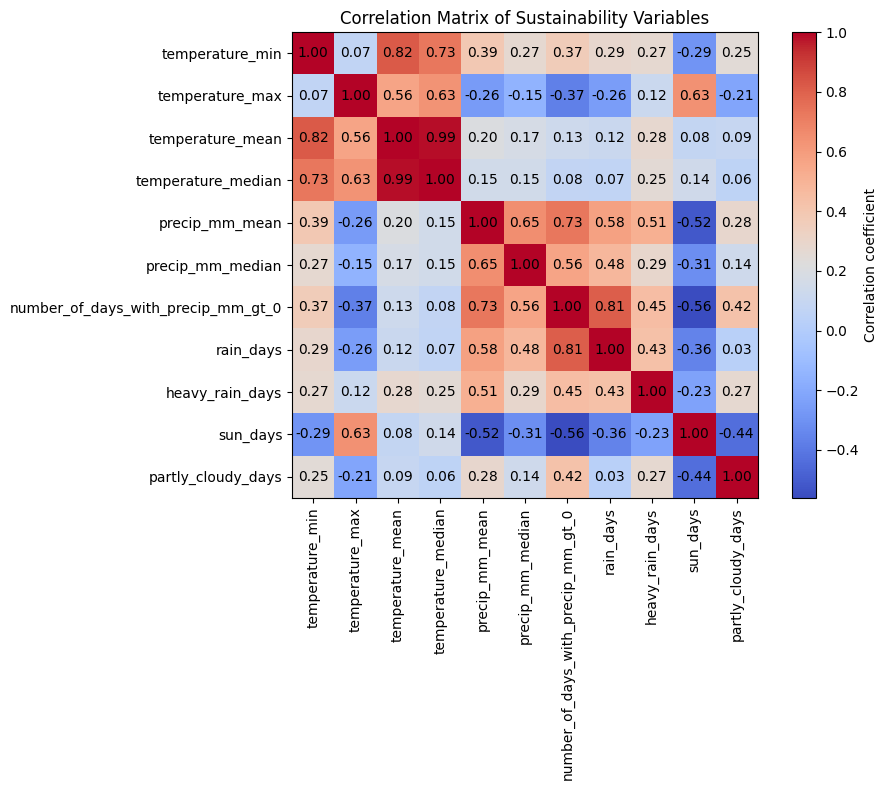

In [41]:
correlation_matrix = df[sustainability_vars].corr()

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap="coolwarm", interpolation="none")
plt.colorbar(label="Correlation coefficient")
plt.xticks(
    range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90
)
plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index)
plt.title("Correlation Matrix of Sustainability Variables")
plt.tight_layout()
for (i, j), val in np.ndenumerate(correlation_matrix.values):
    plt.text(j, i, f"{val:.2f}", ha="center", va="center", color="black")

plt.show()

## Dimensionality diagnosis and reduction (if necessary)

In [42]:
def diagnose_curse_of_dimensionality(data):
    """Detect distance concentration in high-dimensional data"""

    # Calculate nearest neighbor distances
    nbrs = NearestNeighbors(n_neighbors=2)
    nbrs.fit(data)
    distances, indices = nbrs.kneighbors(data)

    # Use distances to second nearest neighbor (index 1)
    nn_distances = distances[:, 1]

    # Calculate distance concentration metric
    min_dist = np.min(nn_distances)
    max_dist = np.max(nn_distances)
    concentration_ratio = max_dist / min_dist if min_dist > 0 else float("inf")

    diagnostics = {
        "dimensionality": data.shape[1],
        "sample_size": data.shape[0],
        "concentration_ratio": concentration_ratio,
        "mean_nn_distance": np.mean(nn_distances),
        "std_nn_distance": np.std(nn_distances),
    }

    print(f"Dimensionality: {diagnostics['dimensionality']}")
    print(f"Sample size: {diagnostics['sample_size']}")
    print(f"Distance concentration ratio: {concentration_ratio:.2f}")

    if concentration_ratio < 2:
        print(
            "⚠️  High distance concentration detected - dimensionality reduction recommended"
        )
    elif concentration_ratio < 5:
        print("⚡ Moderate distance concentration - consider dimensionality reduction")
    else:
        print(
            "✅ Distances well-separated - dimensionality reduction may not be necessary"
        )

    return diagnostics


diagnose_curse_of_dimensionality(df[sustainability_vars])

Dimensionality: 11
Sample size: 185
Distance concentration ratio: 122.90
✅ Distances well-separated - dimensionality reduction may not be necessary


{'dimensionality': 11,
 'sample_size': 185,
 'concentration_ratio': np.float64(122.8955290755821),
 'mean_nn_distance': np.float64(48.12048304677021),
 'std_nn_distance': np.float64(45.666680944024186)}

In [43]:
def compare_dimensionality_reduction_techniques(data, n_clusters=4):
    """Compare PCA, UMAP, and t-SNE for clustering applications"""

    # Standardize data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    results = {}

    # 1. PCA
    pca = PCA(n_components=2)
    pca_embedding = pca.fit_transform(scaled_data)
    pca_clusters = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(
        pca_embedding
    )

    results["PCA"] = {
        "embedding": pca_embedding,
        "clusters": pca_clusters,
        "silhouette": silhouette_score(pca_embedding, pca_clusters),
        "explained_variance": sum(pca.explained_variance_ratio_),
        "interpretability": "High - linear combinations of original variables",
    }

    # 2. UMAP
    reducer = umap.UMAP(n_components=2, random_state=42)
    umap_embedding = reducer.fit_transform(scaled_data)
    umap_clusters = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(
        umap_embedding
    )

    results["UMAP"] = {
        "embedding": umap_embedding,
        "clusters": umap_clusters,
        "silhouette": silhouette_score(umap_embedding, umap_clusters),
        "explained_variance": None,  # Not applicable to UMAP
        "interpretability": "Medium - preserves local and global structure",
    }

    # 3. t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_embedding = tsne.fit_transform(scaled_data)
    tsne_clusters = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(
        tsne_embedding
    )

    results["t-SNE"] = {
        "embedding": tsne_embedding,
        "clusters": tsne_clusters,
        "silhouette": silhouette_score(tsne_embedding, tsne_clusters),
        "explained_variance": None,  # Not applicable to t-SNE
        "interpretability": "Low - preserves local neighborhoods only",
    }

    # 4. No dimensionality reduction (baseline)
    original_clusters = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(
        scaled_data
    )

    results["Original"] = {
        "embedding": None,
        "clusters": original_clusters,
        "silhouette": silhouette_score(scaled_data, original_clusters),
        "explained_variance": 1.0,  # All variance preserved
        "interpretability": "Highest - original variables",
    }

    # Compare cluster agreement
    agreements = {}
    methods = list(results.keys())

    for i, method1 in enumerate(methods):
        for method2 in methods[i + 1 :]:
            ari = adjusted_rand_score(
                results[method1]["clusters"], results[method2]["clusters"]
            )
            agreements[f"{method1} vs {method2}"] = ari

    # Print comparison
    print("Dimensionality Reduction Comparison:")
    print("=" * 50)

    for method, result in results.items():
        print(f"\n{method}:")
        print(f"  Silhouette Score: {result['silhouette']:.3f}")
        if result["explained_variance"]:
            print(f"  Explained Variance: {result['explained_variance']:.3f}")
        print(f"  Interpretability: {result['interpretability']}")

    print(f"\nCluster Agreement (Adjusted Rand Index):")
    for comparison, ari in agreements.items():
        print(f"  {comparison}: {ari:.3f}")

    return results, agreements


def create_decision_matrix():
    """Create a decision matrix for choosing dimensionality reduction techniques"""

    decision_criteria = {
        "Linear relationships": {"PCA": "Excellent", "UMAP": "Good", "t-SNE": "Poor"},
        "Non-linear relationships": {
            "PCA": "Poor",
            "UMAP": "Excellent",
            "t-SNE": "Excellent",
        },
        "Interpretability": {"PCA": "High", "UMAP": "Medium", "t-SNE": "Low"},
        "Computational speed": {"PCA": "Fast", "UMAP": "Medium", "t-SNE": "Slow"},
        "Large datasets": {"PCA": "Excellent", "UMAP": "Good", "t-SNE": "Poor"},
        "Clustering input": {"PCA": "Excellent", "UMAP": "Excellent", "t-SNE": "Fair"},
        "Visualization": {"PCA": "Good", "UMAP": "Excellent", "t-SNE": "Excellent"},
    }

    return pd.DataFrame(decision_criteria)


results, agreements = compare_dimensionality_reduction_techniques(
    df[sustainability_vars], n_clusters=4
)
create_decision_matrix()

/Users/lukasbals/tomorrow-university/12_clustering/clustering-project/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Dimensionality Reduction Comparison:

PCA:
  Silhouette Score: 0.457
  Explained Variance: 0.654
  Interpretability: High - linear combinations of original variables

UMAP:
  Silhouette Score: 0.563
  Interpretability: Medium - preserves local and global structure

t-SNE:
  Silhouette Score: 0.475
  Interpretability: Low - preserves local neighborhoods only

Original:
  Silhouette Score: 0.255
  Explained Variance: 1.000
  Interpretability: Highest - original variables

Cluster Agreement (Adjusted Rand Index):
  PCA vs UMAP: 0.664
  PCA vs t-SNE: 0.634
  PCA vs Original: 0.731
  UMAP vs t-SNE: 0.731
  UMAP vs Original: 0.638
  t-SNE vs Original: 0.629


,Linear relationships,Non-linear relationships,Interpretability,Computational speed,Large datasets,Clustering input,Visualization
PCA,Excellent,Poor,High,Fast,Excellent,Excellent,Good
UMAP,Good,Excellent,Medium,Medium,Good,Excellent,Excellent
t-SNE,Poor,Excellent,Low,Slow,Poor,Fair,Excellent


## Evaluating Dimensionality Reduction Quality

In [44]:
def evaluate_dimensionality_reduction_quality(original_data, reduced_data, method_name):
    """Comprehensive quality assessment for dimensionality reduction"""

    quality_metrics = {}

    # 1. Reconstruction error (for linear methods like PCA)
    if method_name == "PCA":
        try:
            # This would require the PCA transformer to compute reconstruction
            # For demonstration, using approximate reconstruction
            reconstruction_error = np.mean(
                np.var(original_data - np.mean(original_data, axis=0), axis=0)
            )
            quality_metrics["reconstruction_error"] = reconstruction_error
        except:
            quality_metrics["reconstruction_error"] = "Not applicable"

    # 2. Clustering quality comparison
    n_clusters = 4

    # Original space clustering
    kmeans_original = KMeans(n_clusters=n_clusters, random_state=42)
    labels_original = kmeans_original.fit_predict(original_data)
    sil_original = silhouette_score(original_data, labels_original)

    # Reduced space clustering
    kmeans_reduced = KMeans(n_clusters=n_clusters, random_state=42)
    labels_reduced = kmeans_reduced.fit_predict(reduced_data)
    sil_reduced = silhouette_score(reduced_data, labels_reduced)

    quality_metrics["silhouette_original"] = sil_original
    quality_metrics["silhouette_reduced"] = sil_reduced
    quality_metrics["silhouette_improvement"] = sil_reduced - sil_original

    # 3. Neighborhood preservation (trustworthiness and continuity)
    k_neighbors = min(10, len(original_data) - 1)

    # Find k-nearest neighbors in both spaces
    nbrs_original = NearestNeighbors(n_neighbors=k_neighbors + 1)
    nbrs_original.fit(original_data)
    _, neighbors_original = nbrs_original.kneighbors()

    nbrs_reduced = NearestNeighbors(n_neighbors=k_neighbors + 1)
    nbrs_reduced.fit(reduced_data)
    _, neighbors_reduced = nbrs_reduced.kneighbors()

    # Calculate trustworthiness
    trustworthiness = calculate_trustworthiness(
        neighbors_original, neighbors_reduced, k_neighbors
    )
    quality_metrics["trustworthiness"] = trustworthiness

    # 4. Distance preservation (Procrustes analysis)
    from scipy.spatial.distance import pdist, squareform
    from scipy.stats import spearmanr

    dist_original = pdist(original_data)
    dist_reduced = pdist(reduced_data)

    # Correlation between distance matrices
    distance_correlation, _ = spearmanr(dist_original, dist_reduced)
    quality_metrics["distance_correlation"] = distance_correlation

    return quality_metrics


def calculate_trustworthiness(neighbors_original, neighbors_reduced, k):
    """Calculate trustworthiness metric for neighborhood preservation"""

    n_samples = len(neighbors_original)
    trustworthiness = 0

    for i in range(n_samples):
        # Get k-nearest neighbors (excluding self)
        orig_neighbors = set(neighbors_original[i][1 : k + 1])
        reduced_neighbors = set(neighbors_reduced[i][1 : k + 1])

        # Find neighbors in reduced space that weren't in original space
        false_neighbors = reduced_neighbors - orig_neighbors

        # Calculate rank-based penalty
        for j in false_neighbors:
            # Find rank of j in original space for point i
            rank_original = np.where(neighbors_original[i] == j)[0]
            if len(rank_original) > 0:
                rank_penalty = max(0, rank_original[0] - k)
                trustworthiness += rank_penalty

    # Normalization
    max_penalty = n_samples * k * (2 * n_samples - 3 * k - 1) / 2
    trustworthiness = 1 - (2 * trustworthiness) / max_penalty if max_penalty > 0 else 1

    return max(0, min(1, trustworthiness))


def create_quality_report(quality_metrics, method_name):
    """Generate a comprehensive quality assessment report"""

    print(f"Quality Assessment Report: {method_name}")
    print("=" * 50)

    # Clustering quality
    print(f"Clustering Quality:")
    print(f"  Original space silhouette: {quality_metrics['silhouette_original']:.3f}")
    print(f"  Reduced space silhouette:  {quality_metrics['silhouette_reduced']:.3f}")
    improvement = quality_metrics["silhouette_improvement"]
    if improvement > 0:
        print(f"  ✅ Improvement: +{improvement:.3f}")
    else:
        print(f"  ⚠️  Degradation: {improvement:.3f}")

    # Neighborhood preservation
    trust = quality_metrics["trustworthiness"]
    print(f"\nNeighborhood Preservation:")
    print(f"  Trustworthiness: {trust:.3f}")
    if trust > 0.8:
        print(f"  ✅ Excellent neighborhood preservation")
    elif trust > 0.6:
        print(f"  ⚡ Good neighborhood preservation")
    else:
        print(f"  ⚠️  Poor neighborhood preservation")

    # Distance preservation
    dist_corr = quality_metrics["distance_correlation"]
    print(f"\nDistance Preservation:")
    print(f"  Distance correlation: {dist_corr:.3f}")
    if dist_corr > 0.7:
        print(f"  ✅ Strong distance preservation")
    elif dist_corr > 0.4:
        print(f"  ⚡ Moderate distance preservation")
    else:
        print(f"  ⚠️  Weak distance preservation")

    # Overall recommendation
    print(f"\nOverall Assessment:")
    if improvement > 0 and trust > 0.6 and dist_corr > 0.4:
        print(f"  ✅ Recommended - dimensionality reduction improves clustering")
    elif improvement > -0.1 and trust > 0.4:
        print(f"  ⚡ Acceptable - minimal impact on clustering quality")
    else:
        print(f"  ⚠️  Not recommended - consider alternative approaches")


quality_metrics_pca = evaluate_dimensionality_reduction_quality(
    df[sustainability_vars],
    PCA(n_components=2).fit_transform(scaled_results["standard"]["scaled_data"]),
    method_name="PCA",
)
create_quality_report(quality_metrics_pca, method_name="PCA")

quality_metrics_umap = evaluate_dimensionality_reduction_quality(
    df[sustainability_vars],
    umap.UMAP(n_components=2, random_state=42).fit_transform(
        scaled_results["standard"]["scaled_data"]
    ),
    method_name="UMAP",
)
create_quality_report(quality_metrics_umap, method_name="UMAP")

quality_metrics_tsne = evaluate_dimensionality_reduction_quality(
    df[sustainability_vars],
    TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(
        scaled_results["standard"]["scaled_data"]
    ),
    method_name="t-SNE",
)
create_quality_report(quality_metrics_tsne, method_name="t-SNE")

Quality Assessment Report: PCA
Clustering Quality:
  Original space silhouette: 0.332
  Reduced space silhouette:  0.457
  ✅ Improvement: +0.125

Neighborhood Preservation:
  Trustworthiness: 1.000
  ✅ Excellent neighborhood preservation

Distance Preservation:
  Distance correlation: 0.568
  ⚡ Moderate distance preservation

Overall Assessment:
  ✅ Recommended - dimensionality reduction improves clustering


/Users/lukasbals/tomorrow-university/12_clustering/clustering-project/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Quality Assessment Report: UMAP
Clustering Quality:
  Original space silhouette: 0.332
  Reduced space silhouette:  0.563
  ✅ Improvement: +0.231

Neighborhood Preservation:
  Trustworthiness: 1.000
  ✅ Excellent neighborhood preservation

Distance Preservation:
  Distance correlation: 0.395
  ⚠️  Weak distance preservation

Overall Assessment:
  ⚡ Acceptable - minimal impact on clustering quality
Quality Assessment Report: t-SNE
Clustering Quality:
  Original space silhouette: 0.332
  Reduced space silhouette:  0.475
  ✅ Improvement: +0.143

Neighborhood Preservation:
  Trustworthiness: 1.000
  ✅ Excellent neighborhood preservation

Distance Preservation:
  Distance correlation: 0.427
  ⚡ Moderate distance preservation

Overall Assessment:
  ✅ Recommended - dimensionality reduction improves clustering


## Dimension reduction insights

<!-- Quality Assessment Report: PCA
==================================================
Clustering Quality:
  Original space silhouette: 0.332
  Reduced space silhouette:  0.457
  ✅ Improvement: +0.125

Neighborhood Preservation:
  Trustworthiness: 1.000
  ✅ Excellent neighborhood preservation

Distance Preservation:
  Distance correlation: 0.568
  ⚡ Moderate distance preservation

Overall Assessment:
  ✅ Recommended - dimensionality reduction improves clustering
/Users/lukasbals/tomorrow-university/12_clustering/clustering-project/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Quality Assessment Report: UMAP
==================================================
Clustering Quality:
  Original space silhouette: 0.332
  Reduced space silhouette:  0.563
  ✅ Improvement: +0.231

Neighborhood Preservation:
  Trustworthiness: 1.000
  ✅ Excellent neighborhood preservation

Distance Preservation:
  Distance correlation: 0.395
  ⚠️  Weak distance preservation

Overall Assessment:
  ⚡ Acceptable - minimal impact on clustering quality
Quality Assessment Report: t-SNE
==================================================
Clustering Quality:
  Original space silhouette: 0.332
  Reduced space silhouette:  0.475
  ✅ Improvement: +0.143

Neighborhood Preservation:
  Trustworthiness: 1.000
  ✅ Excellent neighborhood preservation

Distance Preservation:
  Distance correlation: 0.427
  ⚡ Moderate distance preservation

Overall Assessment:
  ✅ Recommended - dimensionality reduction improves clustering -->

I evaluated three dimensionality reduction techniques: PCA, UMAP, and t-SNE. UMAP has the best clustering quality improvement, significantly increasing the silhouette score from 0.332 to 0.563. All methods preserved neighborhood structures well, with a trustworthiness score of 1.000. However, UMAP had the weakest distance preservation (0.395), while PCA and t-SNE performed better in this regard.

In [45]:
# Save the standard scaled data to CSV
scaled_standard_df = scaled_results["standard"]["scaled_data"]
scaled_standard_df.to_csv("../data/processed/X_standard_scaled.csv", index=False)

# Apply UMAP and t-SNE dimensionality reduction
umap_embedding = umap.UMAP(n_components=2, random_state=42).fit_transform(
    scaled_standard_df
)
tsne_embedding = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(
    scaled_standard_df
)

# Save the embeddings to CSV
umap_df = pd.DataFrame(umap_embedding, columns=["UMAP1", "UMAP2"])
umap_df.to_csv("../data/processed/X_umap.csv", index=False)

tsne_df = pd.DataFrame(tsne_embedding, columns=["TSNE1", "TSNE2"])
tsne_df.to_csv("../data/processed/X_tsne.csv", index=False)

/Users/lukasbals/tomorrow-university/12_clustering/clustering-project/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/Users/lukasbals/tomorrow-university/12_clustering/clustering-project/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


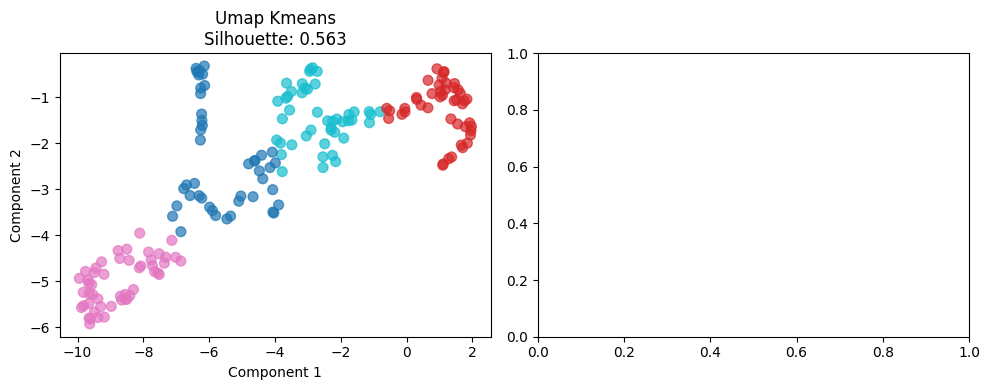

/Users/lukasbals/tomorrow-university/12_clustering/clustering-project/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/lukasbals/tomorrow-university/12_clustering/clustering-project/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/lukasbals/tomorrow-university/12_clustering/clustering-project/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/lukasbals/tomorrow-university/12_clustering/clustering-project/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/lukasbals/tomorrow-university/12_clustering/clustering-project/.venv/

Stability Analysis Results:
original: ARI = 1.000 ± 0.000 (High)
pca_kmeans: ARI = 1.000 ± 0.000 (High)
umap_kmeans: ARI = 1.000 ± 0.000 (High)
Method Comparison:
original: Silhouette=0.255, Dimensions=11, Score=0.245
pca_kmeans: Silhouette=0.307, Dimensions=7, Score=0.307
umap_kmeans: Silhouette=0.563, Dimensions=2, Score=0.563
umap_dbscan: Silhouette=-1.000, Dimensions=2, Score=-1.000

✅ Recommended approach: umap_kmeans


In [46]:
def combined_dimensionality_reduction_clustering(
    data, methods=["pca", "umap"], n_clusters=4
):
    """Compare different dimensionality reduction + clustering combinations"""

    from sklearn.preprocessing import StandardScaler

    # Standardize data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    results = {}

    # Original data clustering (baseline)
    kmeans_original = KMeans(n_clusters=n_clusters, random_state=42)
    labels_original = kmeans_original.fit_predict(scaled_data)

    results["original"] = {
        "labels": labels_original,
        "silhouette": silhouette_score(scaled_data, labels_original),
        "dimensions": scaled_data.shape[1],
    }

    # PCA + K-means
    if "pca" in methods:
        pca = PCA(n_components=0.95)  # Retain 95% variance
        pca_data = pca.fit_transform(scaled_data)

        kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42)
        labels_pca = kmeans_pca.fit_predict(pca_data)

        results["pca_kmeans"] = {
            "labels": labels_pca,
            "silhouette": silhouette_score(pca_data, labels_pca),
            "dimensions": pca_data.shape[1],
            "explained_variance": sum(pca.explained_variance_ratio_),
            "reducer": pca,
            "reduced_data": pca_data,
        }

    # UMAP + K-means
    if "umap" in methods:
        reducer = umap.UMAP(n_components=2, random_state=42)
        umap_data = reducer.fit_transform(scaled_data)

        kmeans_umap = KMeans(n_clusters=n_clusters, random_state=42)
        labels_umap = kmeans_umap.fit_predict(umap_data)

        results["umap_kmeans"] = {
            "labels": labels_umap,
            "silhouette": silhouette_score(umap_data, labels_umap),
            "dimensions": umap_data.shape[1],
            "reducer": reducer,
            "reduced_data": umap_data,
        }

    # UMAP + DBSCAN (density-based clustering in reduced space)
    if "umap" in methods:
        dbscan_umap = DBSCAN(eps=0.5, min_samples=5)
        labels_dbscan_umap = dbscan_umap.fit_predict(umap_data)

        # Only calculate silhouette if we have real clusters (not all noise)
        if len(set(labels_dbscan_umap)) > 1 and -1 not in labels_dbscan_umap:
            silhouette_dbscan = silhouette_score(umap_data, labels_dbscan_umap)
        else:
            silhouette_dbscan = -1  # Invalid clustering

        results["umap_dbscan"] = {
            "labels": labels_dbscan_umap,
            "silhouette": silhouette_dbscan,
            "dimensions": umap_data.shape[1],
            "n_clusters": len(set(labels_dbscan_umap))
            - (1 if -1 in labels_dbscan_umap else 0),
            "noise_points": sum(labels_dbscan_umap == -1),
        }

    return results


def evaluate_combined_approach_stability(data, n_runs=5):
    """Assess stability of combined dimensionality reduction + clustering"""

    stability_results = []

    for run in range(n_runs):
        # Use different random seeds for each run
        results = combined_dimensionality_reduction_clustering(
            data, methods=["pca", "umap"], n_clusters=4
        )
        stability_results.append(results)

    # Calculate agreement across runs for each method
    method_stability = {}

    for method in ["original", "pca_kmeans", "umap_kmeans"]:
        ari_scores = []

        for i in range(len(stability_results)):
            for j in range(i + 1, len(stability_results)):
                if method in stability_results[i] and method in stability_results[j]:
                    ari = adjusted_rand_score(
                        stability_results[i][method]["labels"],
                        stability_results[j][method]["labels"],
                    )
                    ari_scores.append(ari)

        method_stability[method] = {
            "mean_ari": np.mean(ari_scores) if ari_scores else 0,
            "std_ari": np.std(ari_scores) if ari_scores else 0,
            "stability_rating": "High"
            if np.mean(ari_scores) > 0.7
            else "Moderate"
            if np.mean(ari_scores) > 0.4
            else "Low",
        }

    print("Stability Analysis Results:")
    for method, stability in method_stability.items():
        print(
            f"{method}: ARI = {stability['mean_ari']:.3f} ± {stability['std_ari']:.3f} ({stability['stability_rating']})"
        )

    return method_stability


def visualize_combined_results(results):
    """Visualize clustering results from different dimensionality reduction approaches"""

    n_methods = len([k for k in results.keys() if "reduced_data" in results[k]])

    if n_methods == 0:
        print("No reduced-dimension results to visualize")
        return

    fig, axes = plt.subplots(1, n_methods, figsize=(5 * n_methods, 4))
    if n_methods == 1:
        axes = [axes]

    plot_idx = 0
    for method_name, result in results.items():
        if "reduced_data" in result and result["reduced_data"].shape[1] == 2:
            reduced_data = result["reduced_data"]
            labels = result["labels"]

            scatter = axes[plot_idx].scatter(
                reduced_data[:, 0],
                reduced_data[:, 1],
                c=labels,
                cmap="tab10",
                alpha=0.7,
                s=50,
            )

            axes[plot_idx].set_title(
                f"{method_name.replace('_', ' ').title()}\n"
                f"Silhouette: {result['silhouette']:.3f}"
            )
            axes[plot_idx].set_xlabel(f"Component 1")
            axes[plot_idx].set_ylabel(f"Component 2")

            plot_idx += 1

    plt.tight_layout()
    plt.show()


def recommend_best_approach(results):
    """Recommend the best dimensionality reduction + clustering combination"""

    # Scoring criteria: silhouette score, dimensionality reduction, interpretability
    scores = {}

    for method_name, result in results.items():
        silhouette = result["silhouette"]
        dimensions = result["dimensions"]

        # Composite score: favor good clustering with reasonable dimensionality
        dimension_penalty = 0 if dimensions <= 10 else (dimensions - 10) * 0.01
        composite_score = silhouette - dimension_penalty

        scores[method_name] = {
            "silhouette": silhouette,
            "dimensions": dimensions,
            "composite_score": composite_score,
        }

    best_method = max(scores.keys(), key=lambda x: scores[x]["composite_score"])

    print("Method Comparison:")
    for method, score in scores.items():
        print(
            f"{method}: Silhouette={score['silhouette']:.3f}, Dimensions={score['dimensions']}, Score={score['composite_score']:.3f}"
        )

    print(f"\n✅ Recommended approach: {best_method}")

    return best_method, scores


results = combined_dimensionality_reduction_clustering(
    df[sustainability_vars], methods=["pca", "umap"], n_clusters=4
)
visualize_combined_results(results)
stability = evaluate_combined_approach_stability(df[sustainability_vars], n_runs=5)
best_method, scores = recommend_best_approach(results)